# Neural Networks for Data Science Applications
## Homework 1: Saliency maps for interpretability

**Name**: Ludovica Mazza

**Matricola**: 1917778

> ✍ Upload the completed notebook **before 10/11/2023 at 23:59** on the Google Classroom page.

#### Import necessary libraries and connect to drive


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import keras
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import *
from keras.utils import to_categorical
from keras.metrics import categorical_crossentropy
from keras.models import load_model
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Overview

Neural networks are powerful tools, but they are **black-boxes**, meaning that it is difficult to provide human-understandable explanations on what they are doing. The field of **explanaibility** is concerned with finding algorithms for achieving this. In this homework, you will be guided in implementing some basic explanaibility algorithms (**saliency maps**), which is an instructive way of playing with the TensorFlow autodiff framework.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**), and a few optional exercises. Optional exercises are provided if you like the topic and would like to explore more; you are free to ignore them or complete as many as you want. I will not grade them but I might provide feedback for especially nice solutions.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. If your grade does not satisfy you, you are also free to complete the full EoT homework to recover it.
3. The grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

## Warmup: Data loading

For this homework, you can select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

## ✍ **DESCRIPTION OF THE CODE**

I used a Kaggle dataset containing a collection of 1610 lungs X-ray images from various patients.

The goal of this dataset is to perform image classification using convolutional neural networks (CNNs). Specifically, the task is to classify the radiographic images into three categories: healthy, COVID-19-infected or pneumonia virus-infected patients.

NB: The data have already been divided into three different folders:
- normal $\rightarrow$ healthy patients;
- covid $\rightarrow$ covid-infected patients;
- virus $\rightarrow$ patients infected with pneumonia virus.

## **IMPORT DATA**

In [ ]:
# TODO: Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.

In [ ]:
# We define a function to import the data.
# (NB: the data were downloaded from kaggle and imported directly from the drive)

def import_images(directory_path, size):

    images = []

    directory = os.listdir(directory_path)

    for image_name in directory:
        image_path = os.path.join(directory_path, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            # resize image
            image = cv2.resize(image, size)
            images.append(image)

    return images

dir_normal = '/content/drive/MyDrive/NNDS_HW1/COVID_IEEE/normal'
dir_virus = '/content/drive/MyDrive/NNDS_HW1/COVID_IEEE/virus'
dir_covid = '/content/drive/MyDrive/NNDS_HW1/COVID_IEEE/covid'
image_size = (224, 224)

normal = import_images(dir_normal, image_size)
virus = import_images(dir_virus, image_size)
covid = import_images(dir_covid, image_size)

# For convenience, the data was saved in a folder called "original image" so I don't have to apply the import function each time.

In [4]:
# Load pre-saved data
normal_save_path = '/content/drive/MyDrive/NNDS_HW1/original_arrays/normal.npy'
virus_save_path = '/content/drive/MyDrive/NNDS_HW1/original_arrays/virus.npy'
covid_save_path = '/content/drive/MyDrive/NNDS_HW1/original_arrays/covid.npy'

normal = np.load(normal_save_path)
virus = np.load(virus_save_path)
covid = np.load(covid_save_path)

In [5]:
# Let's see how the dataset is made up
print("The Dataset which is made up of {} images has: ".format(len(normal) + len(virus) + len(covid)))
print('{} Normal CXR Image Arrays'.format(len(normal)))
print('{} Viral Pneumonia CXR Image Arrays'.format(len(virus)))
print('{} COVID-19 CXR Image Arrays'.format(len(covid)))

The Dataset which is made up of 1610 images has: 
668 Normal CXR Image Arrays
619 Viral Pneumonia CXR Image Arrays
323 COVID-19 CXR Image Arrays


## **PRE-PROCESSING**

In [6]:
# In order to enhancing the visibility of CXR images I used white balance followed by CLAHE function.
# Reference paper: "A depth-wise separable deep neural network with white balance and CLAHE for detection of COVID-19"

def white_balance(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

def clahe():
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    return clahe

def image_enhancer(image_arrays):
    enchanced_images = []

    for image in image_arrays:

        # White Balance
        image_WB  = np.dstack([white_balance(channel, 0.05) for channel in cv2.split(image)] )
        gray_image = cv2.cvtColor(image_WB, cv2.COLOR_RGB2GRAY)

        # CLAHE
        clahe_function = clahe()
        image_clahe = clahe_function.apply(gray_image)
        image = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)

        enchanced_images.append(image)

    return enchanced_images

# Apply the function ()
normal_wb = image_enhancer(normal)
virus_wb = image_enhancer(virus)
covid_wb = image_enhancer(covid)

In [7]:
# To complete the pre-processing, I normalized the images by dividing by 255.0

def normalize_images(image):

    normalized_images = np.array(image) / 255.0

    return normalized_images

normal_wb_norm = normalize_images(normal_wb)
virus_wb_norm = normalize_images(virus_wb)
covid_wb_norm = normalize_images(covid_wb)

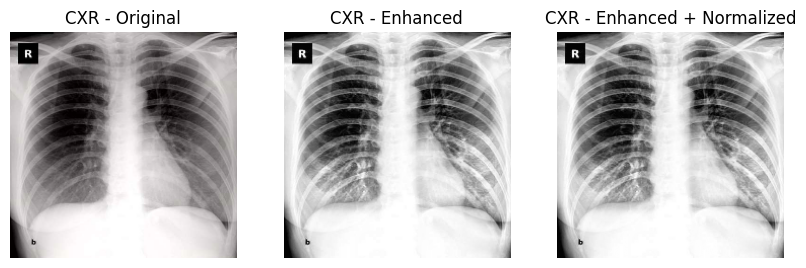

In [8]:
# Let's visualize the images to see the difference

plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 3, 1)
plt.imshow(covid[10])
plt.title("CXR - Original")
plt.axis("off")

ax = plt.subplot(3, 3, 2)
plt.imshow(covid_wb[10])
plt.title("CXR - Enhanced")
plt.axis("off")

ax = plt.subplot(3, 3, 3)
plt.imshow(covid_wb_norm[10])
plt.title("CXR - Enhanced + Normalized")
plt.axis("off")

plt.show()

##**Split in TRAIN,VALIDATION and TEST**

In [9]:
# Split and merge image data and their corresponding labels into training, validation, and test datasets

def split_and_merge(image_arrays, split_factors=[0.6, 0.25, 0.15]):

    # Combine image arrays from all categories
    combined_images = np.vstack(image_arrays)

    # Create labels for the combined images
    labels = np.repeat(np.arange(len(image_arrays)), [len(arr) for arr in image_arrays])

    # Split the combined data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(combined_images, labels, test_size=1 - split_factors[0], random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=split_factors[2] / (split_factors[1] + split_factors[2]), random_state=42)

    datasets = {
        'train_dataset': X_train,
        'validation_dataset': X_val,
        'test_dataset': X_test,
        'train_labels': to_categorical(y_train, num_classes=len(image_arrays)),
        'validation_labels': to_categorical(y_val, num_classes=len(image_arrays)),
        'test_labels': to_categorical(y_test, num_classes=len(image_arrays))
    }

    return datasets


In [10]:
image_arrays = [normal_wb_norm, virus_wb_norm, covid_wb_norm]
datasets = split_and_merge(image_arrays)

In [11]:
# Extract and assign specific datasets and labels to be used later in the train process
train_dataset = datasets['train_dataset']
validation_dataset = datasets['validation_dataset']
test_dataset = datasets['test_dataset']
train_labels = datasets['train_labels']
validation_labels = datasets['validation_labels']
test_labels = datasets['test_labels']

In [12]:
# This is what our data looks like

print("The Dataset which is made up of {} images has been splitted into:".format(len(train_dataset) + len(validation_dataset) + len(test_dataset)))
print('{} Training Image Arrays'.format(len(train_dataset)))
print('{} Validation Image Arrays'.format(len(validation_dataset)))
print('{} Test Image Arrays'.format(len(test_dataset)))

The Dataset which is made up of 1610 images has been splitted into:
966 Training Image Arrays
402 Validation Image Arrays
242 Test Image Arrays


### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function, normalization layers, etc.), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Additional comments and visualizations are also appreciated.

In [ ]:
# TODO: define a suitable neural network.

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=3, activation='softmax'))

    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return model

mymodel = create_model()

# To improve model convergence, I defined ReduceLROnPlateau (a callback in Keras that dynamically adjusts the learning rate)
# Reference Paper:  "End-to-End Deep Diagnosis of X-ray Images"

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
# TODO: train the neural network.
# NB: In order not to have to train all the times, the model was saved and is called up in the cell below the plots.
history = mymodel.fit(train_dataset,train_labels, batch_size = 32,
                    epochs = 30,
                    validation_data = (validation_dataset, validation_labels),
                    callbacks = [learning_rate_reduction])

In [ ]:
# TODO: test the neural network and print the result on screen.

# Evaluate the model
evaluation = mymodel.evaluate(test_dataset, test_labels)

# Evaluation results
loss, accuracy = evaluation
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

8/8 [==============================] - 0s 30ms/step - loss: 0.0880 - accuracy: 0.9628
Test Loss: 0.0880
Test Accuracy: 96.28%


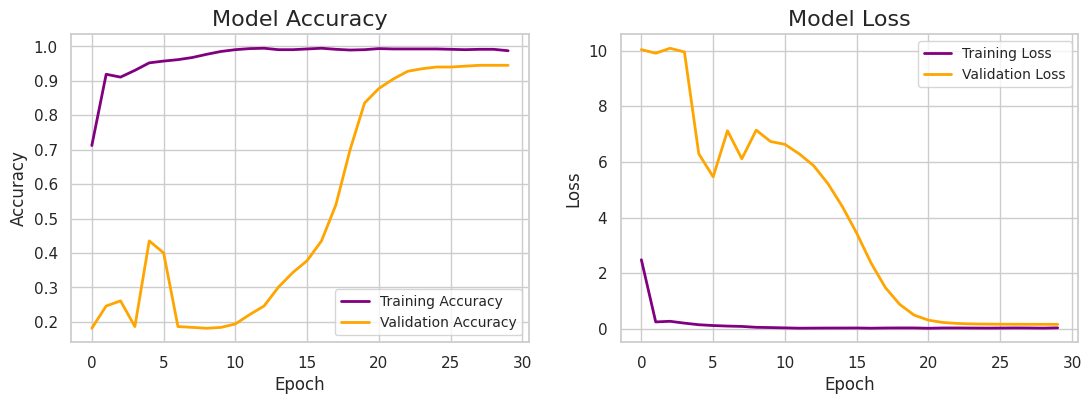

In [ ]:
# To better understand what happens during the training process, let's visualize
# the graphs of loss functions and accuracies of respectively train and validation data

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

# Accuracies
ax1.plot(history.history['accuracy'], label='Training Accuracy', color='purple', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right', fontsize=10)

# Losses
ax2.plot(history.history['loss'], label='Training Loss', color='purple', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
ax2.set_title('Model Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)

plt.show()

In the plotted training history, the effectiveness of the dynamic learning rate adjustment becomes evident: it  played a crucial role in enhancing model accuracy.

In [13]:
# For convenience I saved the model, so now I can import it without having to train it again
mymodel = load_model('/content/drive/MyDrive/NNDS_HW1/mymodel.h5')

### Exercise 2: Computing a vanilla saliency map (1 points)

> Before starting, I suggest you read [1] as a warm-up. This is one of the first papers that tried to apply this kind of techniques to modern neural networks.

What do we mean by explainability? Consider the neural network $f(\cdot)$ you just trained, and a prediction $\hat{y} = f(x)$ we want to analyze. **Feature attribution** methods try to assign a weight $w_i$ to each input feature $x_i$, to understand which parts of the input have contributed the most to the explanation.

The simplest feature attribution technique, called **vanilla saliency map**, simply computes the gradient at that point:

$$
  S(x) = \left\lvert \frac{\partial f_c(x)}{\partial x} \right\rvert
$$

where  $c$ is the index corresponding to the predicted class.

✅ **Completion requirement**: Take any point from your test dataset, and compute a saliency map using `tf.GradientTape`. Check the weight to see if you can find anything to "interpret". **Note**: I am not evaluating how nice / good the explanation is, only the code.

In [16]:
# TODO: Take an element from your test set and compute the saliency map

def vanilla_saliency_map(model, input):

    input = tf.convert_to_tensor(input, dtype=tf.float32)

    # Create a gradient tape to watch the input image
    with tf.GradientTape() as tape:
        tape.watch(input)
        predictions = model(input[tf.newaxis, ...], training = False)
        predicted_class = tf.argmax(predictions[0])
        predicted_class_score = predictions[0][predicted_class]

    # Compute the gradient
    gradients = tape.gradient(predicted_class_score, input)

    # Compute the absolute value of the gradient to obtain the saliency map
    saliency_map = tf.math.abs(gradients)

    # Compute the max saliency map and normalize it to range between 0 and 1 (we need it for the visualization)
    saliency_map_max = tf.reduce_max(saliency_map, axis=-1)
    saliency_map_max_norm = (saliency_map_max - tf.reduce_min(saliency_map_max)) / (tf.reduce_max(saliency_map_max) - tf.reduce_min(saliency_map_max) + 1e-18)

    return saliency_map_max_norm

# Select an image in the test set
input = test_dataset[50]
# Apply the function
saliency_map = vanilla_saliency_map(mymodel, input)

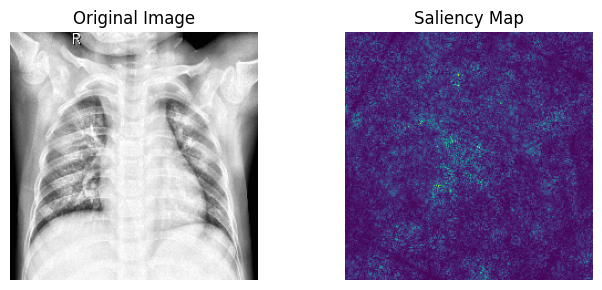

In [17]:
# TODO: Check the saliency map to analyze the result. What can you say about the map?

plt.figure(figsize=(7, 3))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(input)
plt.title("Original Image")
plt.axis("off")

# Saliency map
plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='viridis')
plt.title("Saliency Map")
plt.axis("off")

plt.tight_layout()
plt.show()

The saliency map is a visualization technique used to indicate which parts of the input image are most and least important to a neural network when it was making a decision.
In this context, the saliency map shows the areas of the chest X-ray that the model focused on the most.

What we expect, therefore, is that the saliency map will show the lung region brighter than the rest of the image.
However, what we have in output as a saliency map is a rather uniform image: we can see a region that is slightly brighter in the center but, in general, there is not much difference.
One possible explanation might be that vanilla saliency maps are one of the simplest ways to visualize important regions in an image and they're known to have several limitations, like noisy visualizations, that can be hard to interpret since noise can obscure the relevance of truly important regions.

### Exercise 3: Advanced saliency maps (1 point)

> For this exercise, you can read [2] for an overview on the limits of vanilla saliency maps and a description of SmoothGrad.

Saliency maps have several issues: most notably, they suffer from noise and they are not stable to small changes in the input or in the model (try running again the training and interpreting the same point). Many methods have been proposed to overcome this.

**[SmoothGrad](https://arxiv.org/abs/1706.03825)**, for example, computes multiple saliency maps from noisy versions of the input:

$$
  \text{SmoothGrad}(x) = \frac{1}{n}\sum_{i=1}^n S(x + \varepsilon_i), \;\; \varepsilon_i \sim \mathcal{N}(0, \sigma^2I)
$$

where $\varepsilon$ is a vector of the same shape as $x$, whose values are sampled from a normal distribution with zero mean and small variance.

🟩 **Completion requirement**: Implement the SmoothGrad procedure for the same point. Has the explanation improved? Bonus points if you can avoid running a for-loop, and by calling the gradient operation a single time.


In [ ]:
# TODO: Take an element from your test set and compute SmoothGrad.
# Check the results and compare with respect to the previous exercise.

In [18]:
# Step 1: Define a function to generate noisy samples

def generate_noisy_samples(input, n_samples, stdev):

    input = tf.convert_to_tensor(input, dtype=tf.float32)

    # Add random noise to the image
    noisy_samples = input + tf.random.normal(shape=(n_samples, *input.shape), mean=0, stddev=stdev, dtype=tf.float32)
    return noisy_samples

In [19]:
# Step 2: Compute the smoothgrad saliency map

def smoothgrad_saliency_map(model, input, n_samples, stdev):
    # Generate noisy samples
    noisy_samples = generate_noisy_samples(input, n_samples, stdev)


    # Create a gradient tape
    with tf.GradientTape() as tape:
        tape.watch(noisy_samples)
        predictions = model(noisy_samples, training = False)
        predicted_class = tf.argmax(predictions, axis=1)
        predicted_class_score = tf.reduce_sum(predictions * tf.one_hot(predicted_class, depth=model.output_shape[1]), axis=1)

    # Compute the gradient
    gradients = tape.gradient(predicted_class_score, noisy_samples)

    # Compute the absolute value to obtain the saliency maps for all noisy samples
    saliency_maps = tf.reduce_mean(tf.abs(gradients), axis=0)

    # Normalize the final saliency map for a better visualization
    saliency_map_max = tf.reduce_max(saliency_maps, axis=-1)
    saliency_map_max_norm = (saliency_map_max - tf.reduce_min(saliency_map_max)) / (tf.reduce_max(saliency_map_max) - tf.reduce_min(saliency_map_max) + 1e-18)

    return saliency_map_max_norm

# Select an image
input = test_dataset[50]

# Apply the function (with 4 different levels of noise)
smoothgrad_saliency_map_1 = smoothgrad_saliency_map(mymodel, input, n_samples=50, stdev=0.1)
smoothgrad_saliency_map_2 = smoothgrad_saliency_map(mymodel, input, n_samples=50, stdev=0.3)
smoothgrad_saliency_map_3 = smoothgrad_saliency_map(mymodel, input, n_samples=50, stdev=0.5)
smoothgrad_saliency_map_4 = smoothgrad_saliency_map(mymodel, input, n_samples=50, stdev=0.7)

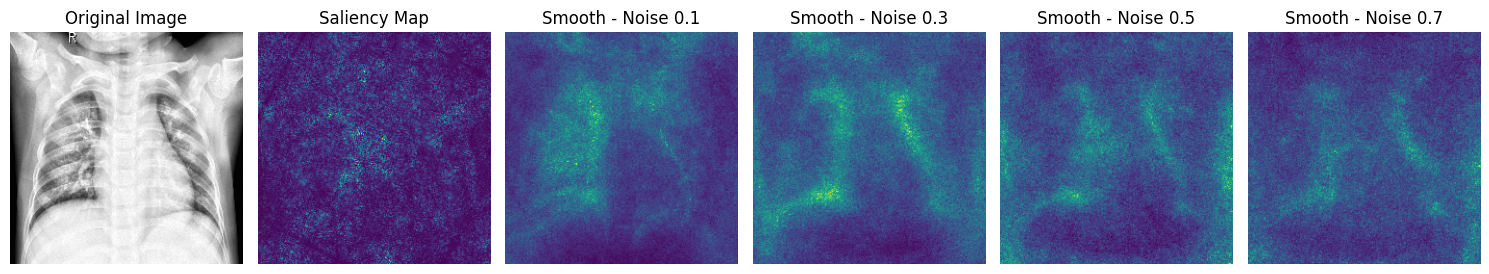

In [20]:
# Display the original image and the saliency map side-by-side
plt.figure(figsize=(15, 15))

# Original image
plt.subplot(1, 6, 1)
plt.imshow(input)
plt.title("Original Image")
plt.axis("off")

# Vanilla Saliency map
plt.subplot(1, 6, 2)
plt.imshow(saliency_map, cmap='viridis')
plt.title("Saliency Map")
plt.axis("off")

# Smooth Saliency map 1
plt.subplot(1, 6, 3)
plt.imshow(smoothgrad_saliency_map_1,cmap='viridis')
plt.title("Smooth - Noise 0.1")
plt.axis("off")

# Smooth Saliency map 2
plt.subplot(1, 6, 4)
plt.imshow(smoothgrad_saliency_map_2,cmap='viridis')
plt.title("Smooth - Noise 0.3")
plt.axis("off")

# Smooth Saliency map 3
plt.subplot(1, 6, 5)
plt.imshow(smoothgrad_saliency_map_3,cmap='viridis')
plt.title("Smooth - Noise 0.5")
plt.axis("off")

# Smooth Saliency map 4
plt.subplot(1, 6, 6)
plt.imshow(smoothgrad_saliency_map_4,cmap='viridis')
plt.title("Smooth - Noise 0.7")
plt.axis("off")

plt.tight_layout()
plt.show()

As was mentioned above, the Smooth Saliency Map is a refined version of the Vanilla Saliency Map where noise reduction technique has been applied.
As we can see in the output, the application of noise reduction worked, managing to highlight the area of the lungs, which represents exactly what the model was trained to focus on, being that it has to distinguish patients with lung disease.

In particular, when applying 10-30% noise, the lung that is most highlighted is the right lung (the one without the heart): apparently the model has detected features in the right lung that it associates with the disease, such as patterns of opacity (a typical feature of covid patients) or other changes that differ from what it has learned to recognize as the "normal" lung.

However, by applying too much noise, the result becomes unclear again: as the noise increases, the relevant signal (features important for prediction) becomes harder to distinguish from the noise, reducing the signal-to-noise ratio and compromising the accuracy of the saliency map.

It may be concluded that the right balance, in my case, is a noise of 0.1.

### Exercise 4: Global explanations (2 points)

The previous exercises are examples of **local** explanations, where we try to interpret a single prediction of the network. Sometimes we are interested in **global** explanations, that try to find common patterns of behaviour. Suppose we have a dataset $\mathcal{T} = \left\{x_i\right\}$ of examples, we can compute some approximate global measure of influence by averaging their saliency:

$$
\text{GlobalSaliency} = \frac{1}{n} \sum_i S(x_i)
$$

To make this exercise more interesting, we will split it into 3 parts.

**Exercise 4.1**: write a function to compute in parallel the saliency for multiple examples. Note that the resulting matrix $S$ will have shape $(n, d)$, where $n$ is the number of examples and $d$ the size of the input, which is the Jacobian of the network. Try to write the function by avoiding for-loops and multiple tapes, using the [proper tools from TensorFlow](https://www.tensorflow.org/guide/advanced_autodiff).

In [21]:
# TODO: Write the required function, possibly avoding for-loops.

def compute_saliency_matrix(model, inputs):

    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)

    # Create a gradient tape
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs, training = False)
        predicted_class = tf.argmax(predictions, axis=1)
        predicted_class_score = tf.reduce_sum(predictions * tf.one_hot(predicted_class, depth=model.output_shape[1]), axis=1)

    # Compute the gradient
    gradients = tape.gradient(predicted_class_score, inputs)

    # Compute the absolute value to obtain the saliency map
    saliency_matrix = tf.abs(gradients)

    # Check if the shape is correct -> it should be 50 (which is the num. of examples * (224,224,3) which is the size of each image)
    # print(saliency_matrix.shape)

    # Normalize the output for a better visualization
    saliency_matrix_max = tf.reduce_max(saliency_matrix, axis=-1)
    saliency_matrix_max_norm = (saliency_matrix_max - tf.reduce_min(saliency_matrix_max)) / (tf.reduce_max(saliency_matrix_max) - tf.reduce_min(saliency_matrix_max) + 1e-18)

    return saliency_matrix_max_norm

inputs= test_dataset[0:50]
saliency_maps = compute_saliency_matrix(mymodel, inputs)

**Exercise 4.2**: write a function to compute the global saliency and try to explain the results.

In [22]:
# TODO: Write the required function.
def compute_global_saliency(saliency_matrices):
    # Sum up the saliency matrices element-wise along the first axis (batch dimension)
    summed_saliency = tf.reduce_sum(saliency_matrices, axis=0)

    # Divide by the number of examples (100 in this case) to get the global saliency
    global_saliency = summed_saliency / len(saliency_matrices)
    return global_saliency

global_saliency_map = compute_global_saliency(saliency_maps)

In [23]:
def visualize_saliencies(original_image, vanilla_saliency, smoothgrad_saliency, global_saliency):
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 4, figsize=(10, 4))

    # Original image
    axes[0].imshow(input)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Vanilla saliency map
    axes[1].imshow(saliency_map)  # You can choose an appropriate colormap
    axes[1].set_title("Vanilla Saliency")
    axes[1].axis("off")

    # SmoothGrad saliency map
    axes[2].imshow(smoothgrad_saliency_map_1)  # You can choose an appropriate colormap
    axes[2].set_title("SmoothGrad Saliency")
    axes[2].axis("off")

    # Global saliency map
    axes[3].imshow(global_saliency_map)  # You can choose an appropriate colormap
    axes[3].set_title("Global Saliency")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

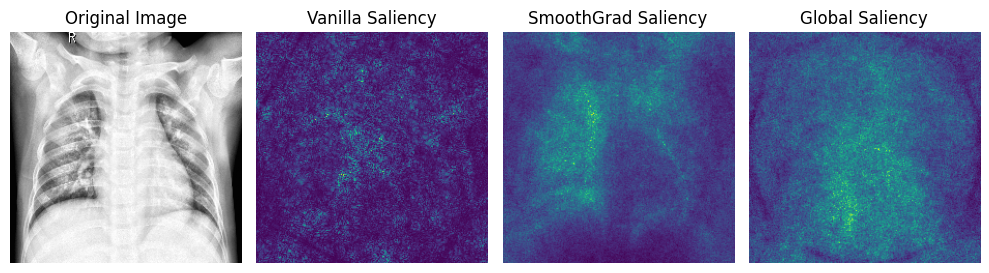

In [24]:
visualize_saliencies(inputs, saliency_map, smoothgrad_saliency_map_1, global_saliency_map)

The global saliency map is essentially the average importance of features across multiple images: it offers a big-picture view of what the model deems important when it classifies.

As can be seen from the output, the Global Saliency shows a more diffuse pattern, with fewer localized bright spots. This suggests that the features highlighted as important , in this case the lung area, are consistent across multiple images, which is exactly what we expect from a model trained to predict lung disease.

**Exercise 4.3**: note that a linear model $f(x) = w^\top x + b$ is an example of an *intrinsically* interpretable  model, since the weights $w$ can be checked to analyze the global saliency of each feature (see [3]).

In [ ]:
# TODO: Compare the results you obtained before with a simpler linear model.

In [28]:
def create_model_linear():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=3, activation='softmax'))
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return model

my_linearmodel = create_model_linear()

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

history_linear = my_linearmodel.fit(train_dataset,train_labels, batch_size = 32,
                    epochs = 30,
                    validation_data = (validation_dataset, validation_labels),
                    callbacks = [learning_rate_reduction,early_stopping])

In [30]:
# Evaluate the linear model
evaluation_linear = my_linearmodel.evaluate(test_dataset, test_labels)

# Evaluation results
linear_loss, linear_accuracy = evaluation_linear
print(f"Test Loss: {linear_loss:.4f}")
print(f"Test Accuracy: {linear_accuracy*100:.2f}%")

8/8 [==============================] - 0s 13ms/step - loss: 0.5695 - accuracy: 0.9256
Test Loss: 0.5695
Test Accuracy: 92.56%


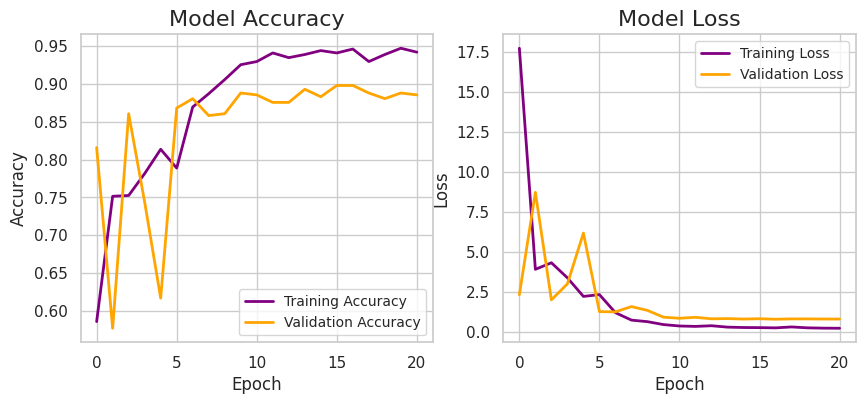

In [31]:
# Linear losses and Accuracies

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Accuracies
ax1.plot(history_linear.history['accuracy'], label='Training Accuracy', color='purple', linewidth=2)
ax1.plot(history_linear.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right', fontsize=10)

# Losses
ax2.plot(history_linear.history['loss'], label='Training Loss', color='purple', linewidth=2)
ax2.plot(history_linear.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
ax2.set_title('Model Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)

plt.show()

In [25]:
# For convenience I saved the model, so now I can import it without having to train it again
my_linearmodel = load_model('/content/drive/MyDrive/NNDS_HW1/my_linearmodel.h5')

In [26]:
# Select the inputs
inputs= test_dataset[0:50]

# Apply the global saliency using the linear model
saliency_maps_lin = compute_saliency_matrix(my_linearmodel, inputs)
global_linear_saliency = compute_global_saliency(saliency_maps_lin)

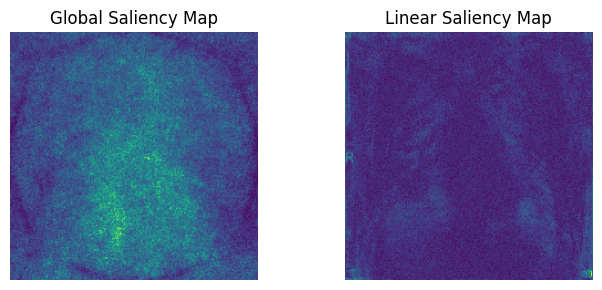

In [27]:
# TODO: Check the saliency map to analyze the result. What can you say about the map?
# Plots to compare

plt.figure(figsize=(7, 3))

# Saliency Map
plt.subplot(1, 2, 1)
plt.imshow(global_saliency_map, cmap='viridis')
plt.title("Global Saliency Map")
plt.axis("off")

# Linear Saliency Map
plt.subplot(1, 2, 2)
plt.imshow(global_linear_saliency, cmap='viridis')
plt.title("Linear Saliency Map")
plt.axis("off")

plt.tight_layout()
plt.show()

We can see that the linear saliency map appears more uniform and less defined than the global saliency generated with a more complex neural network. This is consistent with expectations for a linear model, which lacks the ability to model complex interactions between image features. Important areas are not clearly highlighted, indicating that the linear model cannot accurately identify salient features that are critical to making a decision based on a chest radiographic image.

In more technical terms, a linear model weighs each pixel independently of the others, without taking into account the complex structures or patterns that may be present in the image. This explains why the linear saliency map does not show a clear location of important areas such as the lungs, which would be expected in a chest radiograph.

### Optional exercises and parting words

> ⚠ Explainability is a complex topic, with multiple issues arising from the over-abundance of techniques, their instability, etc. While an interesting research topic to pursue, never use blindly these techniques in high-stake applications!

These exercises were just a brief and short introduction to the topic of explainability. Below you can find some additional exercises to tackle if you are interested. Remember that these are not part of your grade, but I am happy to provide feedback if they are of interest to you.

1. There are dozens of possible variations on feature attribution methods, which may or may not provide better results (see [4] for a benchmarking and this nice [Distill blog post](https://distill.pub/2020/attribution-baselines/)). **[Integrated Gradients](https://arxiv.org/abs/1703.01365)** are an interesting example, where the saliency is integrated over a path ranging from an empty input to the true input. Try implementing integrated gradients.
2. **Data attribution** methods are a different class of explanation methods, which try to predict what points in the dataset where most influential to a given prediction (e.g., a picture of a cat will be especially influential on similar pictures). One example of such methods is TracIn [5], which stores checkpoints of the model during training and evaluates the correlation of the gradients. Try to implement TracIn or any other metric of data influence.
3. A recent line of research tries to use large language models (e.g., ChatGPT) to explain other models (e.g., see [Language models can explain neurons in language models](https://openai.com/research/language-models-can-explain-neurons-in-language-models)). If you have access to an LLM, you can try it! Take a specific neuron in the model, and collect the activation for multiple examples. Provide these activations to the LLM, and prompt it to provide a human-understandable explanation. What is the result?

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 10/11/2023 23:59** on the Google Classrom page.

### Bibliography

[1] Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. [Deep inside convolutional networks: Visualising image classification models and saliency maps](https://arxiv.org/abs/1312.6034). arXiv preprint arXiv:1312.6034.

[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F. and Wattenberg, M., 2017. [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825). arXiv preprint arXiv:1706.03825.

[3] Rudin, C., 2019. [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x). Nature Machine Intelligence, 1(5), pp. 206-215.

[4] Nguyen, G., Kim, D. and Nguyen, A., 2021. [The effectiveness of feature attribution methods and its correlation with automatic evaluation scores](https://proceedings.neurips.cc/paper/2021/hash/de043a5e421240eb846da8effe472ff1-Abstract.html). Advances in Neural Information Processing Systems, 34, pp.26422-26436.

[5] Pruthi, G., Liu, F., Kale, S. and Sundararajan, M., 2020. [Estimating training data influence by tracing gradient descent](https://proceedings.neurips.cc/paper/2020/hash/e6385d39ec9394f2f3a354d9d2b88eec-Abstract.html). Advances in Neural Information Processing Systems, 33, pp. 19920-19930.